In [116]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
# !pip install xgboost
import xgboost
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import pickle
import warnings
# !pip install lightgbm
import lightgbm
# !pip install joblib 
import joblib
import ast
import shap
from sklearn.preprocessing import FunctionTransformer
import datetime as dt
import time


warnings.filterwarnings(action='ignore')

In [117]:
random_state = 19091952

## Cargar dataset SIN FEATURE ENGINEERING para hacerlo en el pipeline

In [118]:
# load data

# df = pd.read_csv('output/model_data.csv', index_col=0)
df = pd.read_csv('dataset.csv', index_col=0)

df.sort_values(by='popularity', inplace=True, ascending=False)

df.head(1).T

,8842
id,6dOtVTDdiauQNBQEDOtlAB
title,BIRDS OF A FEATHER
artist,Billie Eilish
artist_id,6qqNVTkY8uBg9cP3Jd7DAH
album,HIT ME HARD AND SOFT
album_total_tracks,10
disc_number,1
track_number,4
release_date,2024-05-17
duration_ms,210373


### Separar en `train` y `test` al 20%

In [119]:
# features = ['duration_s', 'months_elapsed', 'explicit', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tonalidad', 'tempo', 'time_signature', 'pop', 'hip_hop', 'rock', 'latin', 'key', 'mode', 'artist_followers', 'log_playcounts_per_listener']

# target = "popularity"

# X = df[features]
# y = df[target]

X = df.drop(columns=['popularity'])
y = df['popularity']


# create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


# save training and testing data 
with open('model/X_train.pkl', 'wb') as files:
    pickle.dump(X_train, files)

with open('model/X_test.pkl', 'wb') as files:
    pickle.dump(X_test, files)

with open('model/y_train.pkl', 'wb') as files:
    pickle.dump(y_train, files)

with open('model/y_test.pkl', 'wb') as files:
    pickle.dump(y_test, files)


## Modelado

### Funciones preprocesamiento

In [120]:
def calculate_months_elapsed(df):
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['months_elapsed'] = (dt.datetime.now() - df['release_date']).dt.days / 30
    return df

In [121]:
def convert_duration(df):
    df['duration_s'] = df['duration_ms'] / 1000
    return df

In [122]:
def create_tonalidad(df):
    key_dict = {0: 'Do', 1: 'Do#', 2: 'Re', 3: 'Mib', 4: 'Mi', 5: 'Fa', 6: 'Fa#', 7: 'Sol', 8: 'Sol#', 9: 'La', 10: 'Sib', 11: 'Si'}
    mode_dict = {0: 'm', 1: 'M'}

    key_name = df['key'].map(key_dict)
    mode_name = df['mode'].map(mode_dict)
    df['tonalidad'] = key_name + ' ' + mode_name
    return df

In [123]:
def group_genres(df):
    # Define a list of main genres
    main_genres = ['Pop', 'Rock', 'Hip Hop', 'Indie', 'Country', 'Metal', 'Classical', 'Jazz', 'R&B', 'Reggae', 'Latin', 'Electronic', 'OST']

    # Define a dictionary of main genres and associated subgenres
    genres_dict = {
        'Pop': ['pop rock', 'commercial', 'synthpop', 'contemporary', 'modern', 'pop'],
        'Rock': ['hard rock', 'alternative rock', 'punk rock', 'road', 'garage rock'],
        'Hip Hop': ['rap', 'trap', 'boom bap', 'atl hip hop', 'bases', 'freestyle'],
        'Indie': ['indie rock', 'indie pop', 'indie folk'],
        'Country': ['country rock', 'country pop', 'bluegrass'],
        'Metal': ['heavy metal', 'death metal', 'black metal'],
        'OST' : ['bso', 'bollywood', 'filmi', 'hollywood', 'tollywood', 'soundtrack'],
        'Classical': ['baroque', 'romantic', 'modern classical', 'classic'],
        'Jazz': ['bebop', 'cool jazz', 'free jazz', 'lounge', 'swing', 'jazz'],
        'R&B': ['soul', 'funk', 'neo soul', 'delta blues', 'chicago blues', 'electric blues', 'funk', 'soul'],
        'Reggae': ['ska', 'dancehall', 'dub'],
        'Latin': ['salsa', 'reggaeton', 'latin pop', 'mexicana', 'mariachi', 'mexican', 'spanish', 'latino', 'banda', 'corrido', 'chihuahuense', 'colombian', 'sertanejo', 'arrocha'],
        'Electronic': ['house', 'techno', 'dubstep', 'dance'],
    }

    def map_genres(subgenres):
        # Parse the string into a list
        subgenres_list = ast.literal_eval(subgenres)
        for subgenre in subgenres_list:
            for main_genre, subgenres_in_dict in genres_dict.items():
                # Check if any subgenre in genres_dict is a substring of the subgenre
                if any(sub in subgenre for sub in subgenres_in_dict):
                    return main_genre
                # Check if the main genre is in the subgenre
                elif main_genre.lower() in subgenre.lower():
                    return main_genre
        return 'Otro'  # Return 'Otro' if no main genre is found

    # Apply the function to the artist_genres column
    main_genre = df['artist_genres'].apply(map_genres)
    df['pop'] = (main_genre == 'Pop').astype(int)
    df['rock'] = (main_genre == 'Rock').astype(int)
    df['hip_hop'] = (main_genre == 'Hip Hop').astype(int)
    df['latin'] = (main_genre == 'Latin').astype(int)

    return df

In [124]:
def calculate_log_playcounts_per_listener(df):
    df['lastfm_listeners'].fillna(0, inplace=True)
    df['lastfm_playcounts'].fillna(0, inplace=True)
    playcounts_per_listener = df['lastfm_playcounts'] / df['lastfm_listeners']
    df['log_playcounts_per_listener'] = np.log1p(playcounts_per_listener.fillna(0))

    return df

In [125]:
# Definir la función para eliminar columnas no deseadas
def drop_columns(df, drop_followers=False):
    columns_to_drop = [
        'id', 'title', 'artist', 'artist_id', 'album', 'album_total_tracks', 'disc_number', 'track_number', 'release_date', 'duration_ms',
        'key', 'mode', 'artist_genres', 'lastfm_listeners', 'lastfm_playcounts'
    ]
    if drop_followers:
        columns_to_drop.extend(['artist_followers', 'log_playcounts_per_listener'])
    df = df.drop(columns=columns_to_drop, errors='ignore')
    return df

In [126]:
# Definir una clase personalizada para aplicar múltiples funciones en secuencia
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_followers=True):
        self.drop_followers = drop_followers
        self.label_encoder = LabelEncoder()
    
    def fit(self, X, y=None):
        # Ajustar el LabelEncoder para la columna tonalidad
        X = create_tonalidad(X)
        self.label_encoder.fit(X['tonalidad'])
        return self
    
    def transform(self, X, ohe=False):
        X = calculate_months_elapsed(X)
        X = convert_duration(X)
        X = create_tonalidad(X)
        X['tonalidad'] = self.label_encoder.transform(X['tonalidad'])
        X = group_genres(X)
        X = calculate_log_playcounts_per_listener(X)
        X = drop_columns(X, self.drop_followers)
        if(ohe):
            #OneHotEncoder para la columna "time_signature"
            ct = ColumnTransformer(
                transformers=[('encoder', OneHotEncoder(), ['time_signature'])],
                remainder='passthrough'
            )
            X = ct.transform(X)
        return X
    
    def get_feature_names_out(self, input_features=None):
        return [column for column in self.transform(input_features).columns]

### Pipeline

In [127]:
def create_pipeline(model=False, drop_followers=False):
    ct_columns = ['time_signature']
    ct_ohe = ColumnTransformer(
        transformers=[
            ('one_hot_encode', OneHotEncoder(handle_unknown='ignore'), ct_columns)
        ], 
        remainder='passthrough'
    )
    
    pipeline_steps = [
        ('custom_transform', CustomTransformer(drop_followers=drop_followers)),
        ('one_hot_encode', ct_ohe),
        ('scaler', StandardScaler()),
    ]

    if model is not False:
        pipeline_steps.append(('model', model))

    
    pipeline = Pipeline(steps=pipeline_steps)
    
    return pipeline


### Hiperparámetros

In [128]:
def tune_hyperparameters(pipeline, param_grid, X_train, y_train, rf=False):
  jobs = -1
  if rf:
    jobs = 3
  # grid_search = GridSearchCV(estimator=pipeline, 
  #                             param_grid=param_grid,
  #                             verbose=3,
  #                             cv=3,
  #                             n_jobs=jobs,
  #                             scoring='neg_mean_squared_error')  # Removed random_state and n_iter
  # grid_search.fit(X_train, y_train)
  # return grid_search.best_estimator_

  random_search = RandomizedSearchCV(estimator=pipeline, 
                param_distributions=param_grid,
                verbose=3, # nivel de verbosidad (cuánta informacion se imprime en pantalla)
                cv=5, #3
                n_iter=100, #50,
                scoring='neg_mean_squared_error', # 'neg_mean_absolute_error
                n_jobs=jobs,
                random_state=random_state,
                )
  random_search.fit(X_train, y_train)
  return random_search.best_estimator_

### Evaluación

In [129]:

def evaluate_model(model_name, pipeline, X_test, y_test):
  y_pred = pipeline.predict(X_test)

  mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
  mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true=y_test, y_pred=y_pred)

  print(f'{model_name}:')
  print(f'MAE: {mae}')
  print(f'RMSE: {rmse}')
  print(f'R^2 score: {r2}')
  return [mae, rmse, r2]
    

# Aprendizaje y Evaluación de Modelos

In [130]:
resultados = pd.DataFrame(columns = ['Modelo', 'Dataset', 'Hiperparámetros', 'MAE', 'RMSE', 'R^2', 'Tiempo train (s)'])

## Regresión Lineal (Modelo base)

### COMPLETO

In [131]:
# build a baseline model
lineal = LinearRegression()
lineal_pipeline = create_pipeline(lineal, drop_followers=False)
lineal_pipeline


Pipeline(steps=[('custom_transform', CustomTransformer(drop_followers=False)),
                ('one_hot_encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['time_signature'])])),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

In [132]:
lineal_train_start = time.time()
lineal_pipeline.fit(X_train, y_train)
lineal_train_time = time.time() - lineal_train_start

In [133]:
mae, rmse, r2 = evaluate_model(model_name='Regresión Lineal', pipeline=lineal_pipeline, X_test=X_test, y_test=y_test)

lineal_results = pd.DataFrame({'Modelo': ['Regresión Lineal'],
                            'Dataset': ['Completo'],
                           'Hiperparámetros': [str(lineal)],
                           'MAE': [mae],
                           'RMSE': [rmse],
                           'R^2': [r2],
                           'Tiempo train (s)': [lineal_train_time]})

# Usar pd.concat para agregar la nueva fila
resultados = pd.concat([resultados, lineal_results], ignore_index=True)

with open('model/lineal_pipeline.pkl', 'wb') as files:
    pickle.dump(lineal_pipeline, files)


Regresión Lineal:
MAE: 9.806902121038965
RMSE: 12.771887773182364
R^2 score: 0.5007134202229488


### BÁSICO (sin `artist_followers` ni `lastfm`)

In [134]:
# build a baseline model
lineal_basic = LinearRegression()
lineal_pipeline_basic = create_pipeline(lineal_basic, drop_followers=True)
lineal_pipeline_basic

Pipeline(steps=[('custom_transform', CustomTransformer()),
                ('one_hot_encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['time_signature'])])),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

In [135]:
lineal_train_start_basic = time.time()
lineal_pipeline_basic.fit(X_train, y_train)
lineal_train_time_basic = time.time() - lineal_train_start_basic

In [136]:
mae, rmse, r2 = evaluate_model(model_name='Regresión Lineal', pipeline=lineal_pipeline_basic, X_test=X_test, y_test=y_test)

lineal_results_basic = pd.DataFrame({'Modelo': ['Regresión Lineal'],
                            'Dataset': ['Básico'],
                           'Hiperparámetros': [str(lineal_basic)],
                           'MAE': [mae],
                           'RMSE': [rmse],
                           'R^2': [r2],
                           'Tiempo train (s)': [lineal_train_time_basic]})

# Usar pd.concat para agregar la nueva fila
resultados = pd.concat([resultados, lineal_results_basic], ignore_index=True)

with open('model/lineal_pipeline.pkl', 'wb') as files:
    pickle.dump(lineal_pipeline_basic, files)



Regresión Lineal:
MAE: 13.594144669329625
RMSE: 16.787762258292876
R^2 score: 0.13736847394803675


### Resultados

In [137]:
resultados

,Modelo,Dataset,Hiperparámetros,MAE,RMSE,R^2,Tiempo train (s)
0,Regresión Lineal,Completo,LinearRegression(),9.806902,12.771888,0.500713,2.219132
1,Regresión Lineal,Básico,LinearRegression(),13.594145,16.787762,0.137368,2.181641


## Regresión de Lasso

### COMPLETO

In [138]:

lasso = Lasso(random_state=random_state)
lasso_pipeline = create_pipeline(model=lasso, drop_followers=False)
lasso_pipeline

Pipeline(steps=[('custom_transform', CustomTransformer(drop_followers=False)),
                ('one_hot_encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['time_signature'])])),
                ('scaler', StandardScaler()),
                ('model', Lasso(random_state=19091952))])

In [139]:
param_grid_lasso = {
    'model__alpha': np.arange(0.00, 1.01, 0.01)
}

lasso_train_start = time.time()
best_lasso = tune_hyperparameters(pipeline=lasso_pipeline, param_grid=param_grid_lasso, X_train=X_train, y_train=y_train)
lasso_train_time = time.time() - lasso_train_start
best_lasso[-1]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


Lasso(alpha=0.0, random_state=19091952)

In [140]:
mae, rmse, r2 = evaluate_model(model_name='Lasso', pipeline=best_lasso, X_test=X_test, y_test=y_test)

lasso_results = pd.DataFrame({'Modelo': ['Lasso'],
                            'Dataset': ['Completo'],
                            'Hiperparámetros': [str(best_lasso[-1])],
                            'MAE': [mae],
                            'RMSE': [rmse],
                            'R^2': [r2],
                            'Tiempo train (s)': [lasso_train_time]})

# Usar pd.concat para agregar la nueva fila
resultados = pd.concat([resultados, lasso_results], ignore_index=True)

with open('model/lasso_model.pkl', 'wb') as files:
    pickle.dump(best_lasso, files)

Lasso:
MAE: 9.806284283869303
RMSE: 12.771407181584992
R^2 score: 0.5007509946872104


### BÁSICO (sin `artist_followers` ni `lastfm`)

In [639]:
lasso_basic = Lasso(random_state=random_state)
lasso_pipeline_basic = create_pipeline(model=lasso, drop_followers=True)
lasso_pipeline_basic

Pipeline(steps=[('custom_transform', CustomTransformer()),
                ('one hot encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['time_signature'])])),
                ('scaler', StandardScaler()),
                ('model', Lasso(random_state=19091952))])

In [640]:
param_grid_lasso_basic = {
    'model__alpha': np.arange(0.00, 1.01, 0.01)
}

lasso_train_start_basic = time.time()
best_lasso_basic = tune_hyperparameters(pipeline=lasso_pipeline_basic, param_grid=param_grid_lasso_basic, X_train=X_train, y_train=y_train)
lasso_train_time_basic = time.time() - lasso_train_start_basic
best_lasso_basic[-1]

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END ..............model__alpha=0.79;, score=-288.433 total time=   2.2s
[CV 2/3] END ..............model__alpha=0.79;, score=-287.086 total time=   2.2s
[CV 3/3] END ..............model__alpha=0.79;, score=-286.828 total time=   2.2s
[CV 1/3] END ..............model__alpha=0.33;, score=-284.099 total time=   2.2s
[CV 2/3] END ..............model__alpha=0.33;, score=-282.504 total time=   2.2s
[CV 3/3] END ..............model__alpha=0.33;, score=-282.331 total time=   2.2s
[CV 1/3] END model__alpha=0.41000000000000003;, score=-284.932 total time=   2.2s
[CV 2/3] END model__alpha=0.41000000000000003;, score=-283.275 total time=   2.1s
[CV 3/3] END model__alpha=0.41000000000000003;, score=-283.099 total time=   2.2s
[CV 1/3] END model__alpha=0.9400000000000001;, score=-290.366 total time=   2.2s
[CV 2/3] END model__alpha=0.9400000000000001;, score=-289.013 total time=   2.2s
[CV 3/3] END model__alpha=0.9400000000000001

Lasso(alpha=0.0, random_state=19091952)

In [641]:
mae, rmse, r2 = evaluate_model(model_name='Lasso', pipeline=best_lasso_basic, X_test=X_test, y_test=y_test)

lasso_results_basic = pd.DataFrame({'Modelo': ['Lasso'],
                            'Dataset': ['Básico'],
                            'Hiperparámetros': [str(best_lasso_basic[-1])],
                            'MAE': [mae],
                            'RMSE': [rmse],
                            'R^2': [r2],
                            'Tiempo train (s)': [lasso_train_time_basic]})

# Usar pd.concat para agregar la nueva fila
resultados = pd.concat([resultados, lasso_results_basic], ignore_index=True)

with open('model/lasso_model_basic.pkl', 'wb') as files:
    pickle.dump(best_lasso_basic, files)

Lasso:
MAE: 13.594107883136878
RMSE: 16.78784434858144
R^2 score: 0.13736003758314874


### Resultados

In [642]:
resultados

,Modelo,Dataset,Hiperparámetros,MAE,RMSE,R^2,Tiempo train (s)
0,Regresión Lineal,Completo,LinearRegression(),9.806902,12.771888,0.500713,2.390522
1,Regresión Lineal,Básico,LinearRegression(),13.594145,16.787762,0.137368,2.269814
2,Lasso,Completo,"Lasso(alpha=0.0, random_state=19091952)",9.806284,12.771407,0.500751,368.764107
3,Lasso,Básico,"Lasso(alpha=0.0, random_state=19091952)",13.594108,16.787844,0.137360,366.164167


## Random Forest Regression

### COMPLETO

In [643]:
rf = RandomForestRegressor(random_state=random_state, n_jobs=3)
rf_pipeline = create_pipeline(model=rf, drop_followers=False)
rf_pipeline

Pipeline(steps=[('custom_transform', CustomTransformer(drop_followers=False)),
                ('one hot encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['time_signature'])])),
                ('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(n_jobs=3, random_state=19091952))])

In [644]:
param_grid_rf = {
    'model__n_estimators': np.arange(500, 1100, 200),
    'model__min_samples_leaf': [3,4,5],
    'model__min_samples_split': [2,5,10],
    'model__max_depth': [10, 30, 50]
}

rf_train_start = time.time()
best_rf = tune_hyperparameters(pipeline=rf_pipeline, param_grid=param_grid_rf, X_train=X_train, y_train=y_train, rf=True)
rf_train_time = time.time() - rf_train_start
best_rf[-1]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomForestRegressor(max_depth=30, min_samples_leaf=3, min_samples_split=5,
                      n_estimators=900, n_jobs=3, random_state=19091952)

In [646]:
mae, rmse, r2 = evaluate_model(model_name='Random Forest', pipeline=best_rf, X_test=X_test, y_test=y_test)

rf_results = pd.DataFrame({'Modelo': ['Random Forest'],
                            'Dataset': ['Completo'],
                            'Hiperparámetros': [str(best_rf[-1])],
                            'MAE': [mae],
                            'RMSE': [rmse],
                            'R^2': [r2],
                            'Tiempo train (s)': [rf_train_time]})
resultados = pd.concat([resultados, rf_results], ignore_index=True)

with open('model/rf_model.pkl', 'wb') as files:
    pickle.dump(best_rf, files)

Random Forest:
MAE: 7.6704814912184105
RMSE: 10.37007924736984
R^2 score: 0.6708424236028901


### BÁSICO (sin `artist_followers` ni `lastfm`)

In [647]:
rf_basic = RandomForestRegressor(random_state=random_state, n_jobs=3)
rf_pipeline_basic = create_pipeline(model=rf, drop_followers=True)
rf_pipeline_basic

Pipeline(steps=[('custom_transform', CustomTransformer()),
                ('one hot encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['time_signature'])])),
                ('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(n_jobs=3, random_state=19091952))])

In [648]:
param_grid_rf_basic = {
    'model__n_estimators': np.arange(500, 1100, 200),
    'model__min_samples_leaf': [3,4,5],
    'model__min_samples_split': [2,5,10],
    'model__max_depth': [10, 30, 50]
}

rf_train_start_basic = time.time()
best_rf_basic = tune_hyperparameters(pipeline=rf_pipeline_basic, param_grid=param_grid_rf_basic, X_train=X_train, y_train=y_train, rf=True)
rf_train_time_basic = time.time() - rf_train_start_basic
best_rf_basic[-1]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
mae, rmse, r2 = evaluate_model(model_name='Random Forest', pipeline=best_rf_basic, X_test=X_test, y_test=y_test)

rf_results_basic = pd.DataFrame({'Modelo': ['Random Forest'],
                            'Dataset': ['Básico'],
                            'Hiperparámetros': [str(best_rf_basic[-1])],
                            'MAE': [mae],
                            'RMSE': [rmse],
                            'R^2': [r2],
                            'Tiempo train (s)': [rf_train_time_basic]})
resultados = pd.concat([resultados, rf_results_basic], ignore_index=True)

with open('model/rf_model_basic.pkl', 'wb') as files:
    pickle.dump(best_rf_basic, files)



### Resultados

In [ ]:
resultados

## LightGBM Regressor

### COMPLETO

In [ ]:
lgbm = lightgbm.LGBMRegressor(random_state=random_state, n_jobs=3)
lgbm_pipeline = create_pipeline(model=lgbm, drop_followers=False)
lgbm_pipeline


Pipeline(steps=[('custom_transform', CustomTransformer(drop_followers=False)),
                ('one hot encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['time_signature'])])),
                ('scaler', StandardScaler()),
                ('model', LGBMRegressor(n_jobs=3, random_state=19091952))])

In [ ]:
param_grid_lgbm = {
    'model__learning_rate': [i*0.01 for i in range(1,101)],
    'model__num_leaves': [5,6,7,8,9,10],
    'model__max_depth': [3,4,5,6,7,8,9,10],
    'model__min_child_weight':[1,2,3,4,5,6]
}

lgbm_train_start = time.time()
best_lgbm = tune_hyperparameters(pipeline=lgbm_pipeline, param_grid=param_grid_lgbm, X_train=X_train, y_train=y_train)
lgbm_train_time = time.time() - lgbm_train_start
best_lgbm[-1]

Fitting 3 folds for each of 28800 candidates, totalling 86400 fits


KeyboardInterrupt: 

In [ ]:
mae, rmse, r2 = evaluate_model(model_name='LightGBM', pipeline=best_lgbm, X_test=X_test, y_test=y_test)

lgbm_results = pd.DataFrame({'Modelo': ['LightGBM'],
                            'Dataset': ['Completo'],
                            'Hiperparámetros': [str(best_lgbm[-1])],
                            'MAE': [mae],
                            'RMSE': [rmse],
                            'R^2': [r2],
                            'Tiempo train (s)': [lgbm_train_time]})

resultados = pd.concat([resultados, lgbm_results], ignore_index=True)

with open('model/lgbm_model.pkl', 'wb') as files:
    pickle.dump(best_lgbm, files)

LightGBM:
MAE: 8.217916283006396
RMSE: 10.879637576291428
R^2 score: 0.637699809732647


### BÁSICO (sin `artist_followers` ni `lastfm`)

In [ ]:
lgbm_basic = lightgbm.LGBMRegressor(random_state=random_state, n_jobs=3)
lgbm_pipeline_basic = create_pipeline(model=lgbm_basic, drop_followers=True)
lgbm_pipeline_basic

Pipeline(steps=[('custom_transform', CustomTransformer()),
                ('one hot encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['time_signature'])])),
                ('scaler', StandardScaler()),
                ('model', LGBMRegressor(n_jobs=3, random_state=19091952))])

In [ ]:
param_grid_lgbm_basic = {
    'model__learning_rate': [i*0.01 for i in range(1,101)],
    'model__num_leaves': [5,6,7,8,9,10],
    'model__max_depth': [3,4,5,6,7,8,9,10],
    'model__min_child_weight':[1,2,3,4,5,6]
}

lgbm_train_start_basic = time.time()
best_lgbm_basic = tune_hyperparameters(pipeline=lgbm_pipeline_basic, param_grid=param_grid_lgbm_basic, X_train=X_train, y_train=y_train)
lgbm_train_time_basic = time.time() - lgbm_train_start_basic
best_lgbm_basic[-1]

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2854
[LightGBM] [Info] Number of data points in the train set: 110734, number of used features: 20
[LightGBM] [Info] Start training from score 27.617787
[CV 1/3] END model__learning_rate=0.9, model__max_depth=4, model__min_child_weight=4, model__num_leaves=7;, score=-252.604 total time=   2.2s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2854
[LightGBM] [Info] Number of data points in the train set: 110734, number of used features: 20
[LightGBM] [Info] Start training f

LGBMRegressor(learning_rate=0.56, max_depth=9, min_child_weight=6, n_jobs=3,
              num_leaves=10, random_state=19091952)

In [ ]:
mae, rmse, r2 = evaluate_model(model_name='LightGBM', pipeline=best_lgbm_basic, X_test=X_test, y_test=y_test)

lgbm_results_basic = pd.DataFrame({'Modelo': ['LightGBM'],
                            'Dataset': ['Básico'],
                            'Hiperparámetros': [str(best_lgbm_basic[-1])],
                            'MAE': [mae],
                            'RMSE': [rmse],
                            'R^2': [r2],
                            'Tiempo train (s)': [lgbm_train_time_basic]})

resultados = pd.concat([resultados, lgbm_results_basic], ignore_index=True)

with open('model/lgbm_model_basic.pkl', 'wb') as files:
    pickle.dump(best_lgbm_basic, files)


LightGBM:
MAE: 12.437886736638573
RMSE: 15.646726276785502
R^2 score: 0.25064661123764376


### Resultados

In [ ]:
resultados

,Modelo,Dataset,Hiperparámetros,MAE,RMSE,R^2,Tiempo train (s)
0,Regresión Lineal,Completo,LinearRegression(),9.806902,12.771888,0.500713,2.450491
1,Regresión Lineal,Básico,LinearRegression(),13.594145,16.787762,0.137368,2.275001
2,Lasso,Completo,"Lasso(alpha=0.0, random_state=19091952)",9.806284,12.771407,0.500751,106.033154
3,Lasso,Básico,"Lasso(alpha=0.0, random_state=19091952)",13.594108,16.787844,0.137360,104.241224
5,LightGBM,Completo,"LGBMRegressor(learning_rate=0.74, max_depth=6,...",8.217916,10.879638,0.637700,370.929645
6,LightGBM,Básico,"LGBMRegressor(learning_rate=0.56, max_depth=9,...",12.437887,15.646726,0.250647,380.804657


## XGBoost Regressor

### COMPLETO

In [16]:
xgb = xgboost.XGBRegressor(random_state=random_state, n_jobs=3)
xgb_pipeline = create_pipeline(model=xgb, drop_followers=False)
xgb_pipeline

Pipeline(steps=[('custom_transform', CustomTransformer(drop_followers=False)),
                ('one hot encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['time_signature'])])),
                ('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsam...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=3,
                              num_parallel_tree=None, random_state=19091952, ...))])

In [17]:
param_grid_xgb = {
        'model__eta': [i*0.01 for i in range(1,101)],
        'model__gamma': [i/10.0 for i in range(0,6)],
        'model__max_depth': [3,4,5,6,7,8,9,10],
        'model__min_child_weight':[1,2,3,4,5,6],
        'model__subsample': [0.5, 0.7, 1]
        }

xgb_train_start = time.time()
best_xgb = tune_hyperparameters(pipeline=xgb_pipeline, param_grid=param_grid_xgb, X_train=X_train, y_train=y_train)
xgb_train_time = time.time() - xgb_train_start
best_xgb[-1]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [ ]:
mae, rmse, r2 = evaluate_model(model_name='XGBoost', pipeline=best_xgb, X_test=X_test, y_test=y_test)

xgb_results = pd.DataFrame({'Modelo': ['XGBoost'],
                            'Dataset': ['Completo'],
                            'Hiperparámetros': [str(best_xgb[-1])],
                            'MAE': [mae],
                            'RMSE': [rmse],
                            'R^2': [r2],
                            'Tiempo train (s)': [xgb_train_time]})

resultados = pd.concat([resultados, xgb_results], ignore_index=True)

with open('model/xgb_model.pkl', 'wb') as files:
    pickle.dump(best_xgb, files)

XGBoost:
MAE: 7.357538730150127
RMSE: 9.957523588475995
R^2 score: 0.6965113923268225


### BÁSICO (sin `artist_followers` ni `lastfm`)

In [675]:
xgb_basic = xgboost.XGBRegressor(random_state=random_state, n_jobs=3)
xgb_pipeline_basic = create_pipeline(model=xgb_basic, drop_followers=True)
xgb_pipeline_basic

Pipeline(steps=[('custom_transform', CustomTransformer()),
                ('one hot encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['time_signature'])])),
                ('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              cols...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=3,
                              num_parallel_tree=None, random_state=19091952, ...))])

In [676]:
param_grid_xgb_basic = {
        'model__eta': [i*0.01 for i in range(1,101)],
        'model__gamma': [i/10.0 for i in range(0,6)],
        'model__max_depth': [3,4,5,6,7,8,9,10],
        'model__min_child_weight':[1,2,3,4,5,6],
        'model__subsample': [0.5, 0.7, 1]
        }

xgb_train_start_basic = time.time()
best_xgb_basic = tune_hyperparameters(pipeline=xgb_pipeline_basic, param_grid=param_grid_xgb_basic, X_train=X_train, y_train=y_train)
xgb_train_time_basic = time.time() - xgb_train_start_basic
best_xgb_basic[-1]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.11, eval_metric=None,
             feature_types=None, gamma=0.4, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=2, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=3, num_parallel_tree=None, ...)

In [677]:
mae, rmse, r2 = evaluate_model(model_name='XGBoost', pipeline=best_xgb_basic, X_test=X_test, y_test=y_test)

xgb_results_basic = pd.DataFrame({'Modelo': ['XGBoost'],
                            'Dataset': ['Básico'],
                            'Hiperparámetros': [str(best_xgb_basic[-1])],
                            'MAE': [mae],
                            'RMSE': [rmse],
                            'R^2': [r2],
                            'Tiempo train (s)': [xgb_train_time_basic]})

resultados = pd.concat([resultados, xgb_results_basic], ignore_index=True)

with open('model/xgb_model_basic.pkl', 'wb') as files:
    pickle.dump(best_xgb_basic, files)

XGBoost:
MAE: 12.031962747685029
RMSE: 15.23354309045917
R^2 score: 0.2897004227527391


### Resultados

In [678]:
resultados

,Modelo,Dataset,Hiperparámetros,MAE,RMSE,R^2,Tiempo train (s)
0,Regresión Lineal,Completo,LinearRegression(),9.806902,12.771888,0.500713,2.345646
1,Regresión Lineal,Básico,LinearRegression(),13.594145,16.787762,0.137368,2.175547
2,XGBoost,Completo,"XGBRegressor(base_score=None, booster=None, ca...",7.357539,9.957524,0.696511,287.873343
3,XGBoost,Básico,"XGBRegressor(base_score=None, booster=None, ca...",12.031963,15.233543,0.289700,279.385639


In [684]:
#get not None params
best_xgb.get_params()['model'].get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.2,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': 6,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': 3,
 'num_parallel_tree': None,
 'random_state': 19091952,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.21}

In [685]:
best_xgb_basic.get_params()['model'].get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.4,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': 2,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': 3,
 'num_parallel_tree': None,
 'random_state': 19091952,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.11}

# Resultados FINALES

In [ ]:
# show results of all models
resultados

,Modelo,Dataset,Hiperparámetros,MAE,RMSE,R^2,Tiempo train (s)
0,Regresión Lineal,Completo,LinearRegression(),9.806902,12.771888,0.500713,2.450491
1,Regresión Lineal,Básico,LinearRegression(),13.594145,16.787762,0.137368,2.275001
2,Lasso,Completo,"Lasso(alpha=0.0, random_state=19091952)",9.806284,12.771407,0.500751,106.033154
3,Lasso,Básico,"Lasso(alpha=0.0, random_state=19091952)",13.594108,16.787844,0.137360,104.241224
4,LightGBM,Completo,"LGBMRegressor(learning_rate=0.74, max_depth=6,...",8.217916,10.879638,0.637700,370.929645
5,LightGBM,Básico,"LGBMRegressor(learning_rate=0.56, max_depth=9,...",12.437887,15.646726,0.250647,380.804657
6,XGBoost,Completo,"XGBRegressor(base_score=None, booster=None, ca...",7.352639,9.950831,0.696919,448.328973
7,XGBoost,Básico,"XGBRegressor(base_score=None, booster=None, ca...",12.076481,15.276597,0.285680,438.725251


In [ ]:
with open('output/resultados.pkl', 'wb') as files:
    pickle.dump(resultados, files)

resultados.to_csv('output/resultados.csv', index=False)

### SHAP para el mejor modelo

### COMPLETO

In [115]:
# Define the column lists
categorical_columns = ['time_signature']
numerical_columns = X.select_dtypes(include=[np.number]).columns

# Define the preprocessor for categorical and numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ])

# Create the complete pipeline with CustomTransformer included
xgb_pipeline = Pipeline(steps=[
    ('custom_preprocessor', CustomTransformer()),  # Assuming this is your custom transformer
    ('preprocessor', preprocessor),
    ('model', xgboost.XGBRegressor(
        eta=0.21,
        gamma=0.2,
        max_depth=10,
        min_child_weight=6,
        subsample=1,
        random_state=random_state,
        n_jobs=3))
])

xgb = xgboost.XGBRegressor(
    eta=0.21,
    gamma=0.2,
    max_depth=10,
    min_child_weight=6,
    subsample=1,
    random_state=random_state,
    n_jobs=3
)

X_train_transformed = xgb_pipeline.named_steps['custom_preprocessor'].fit_transform(X_train)
X_train_preprocessed = xgb_pipeline.named_steps['preprocessor'].transform(X_train_transformed, drop_columns=False)


# Check the shape to ensure it has the expected number of columns
print(X_train_transformed.shape)

ValueError: Passing extra keyword arguments to ColumnTransformer.transform is only supported if enable_metadata_routing=True, which you can set using `sklearn.set_config`. See the User Guide <https://scikit-learn.org/stable/metadata_routing.html> for more details. Extra parameters passed are: {'drop_columns'}

In [95]:
# Assuming 'column_transformer' is your fitted ColumnTransformer
column_transformer = xgb_pipeline.named_steps['one_hot_encode']

# Step 1: Get all output feature names
all_feature_names = column_transformer.get_feature_names_out()

# Step 2: Get names of features transformed by specific transformers
# This requires knowing the names of the transformers or iterating over them
transformed_feature_names = []
for transformer_name, transformer, feature_names in column_transformer.transformers_:
    if transformer_name != 'remainder':
        transformed_feature_names.extend(transformer.get_feature_names_out(feature_names))

# Step 3: Identify passthrough columns by excluding transformed features from all features
passthrough_columns = [name for name in all_feature_names if name not in transformed_feature_names]
passthrough_columns = [col[col.index('__') + 2:] for col in passthrough_columns]
# Print or use the passthrough column names
print(passthrough_columns)

['time_signature_3', 'time_signature_4', 'time_signature_5', 'explicit', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'artist_followers', 'tonalidad', 'months_elapsed', 'duration_s', 'pop', 'rock', 'hip_hop', 'latin', 'log_playcounts_per_listener']


In [96]:
xgb_pipeline[:-1]

Pipeline(steps=[('custom_transform', CustomTransformer(drop_followers=False)),
                ('one_hot_encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['time_signature'])])),
                ('scaler', StandardScaler())])

In [103]:
X_train_transformed = xgb_pipeline[:-1].transform(X_train)
X_train_transformed.shape

(166101, 22)

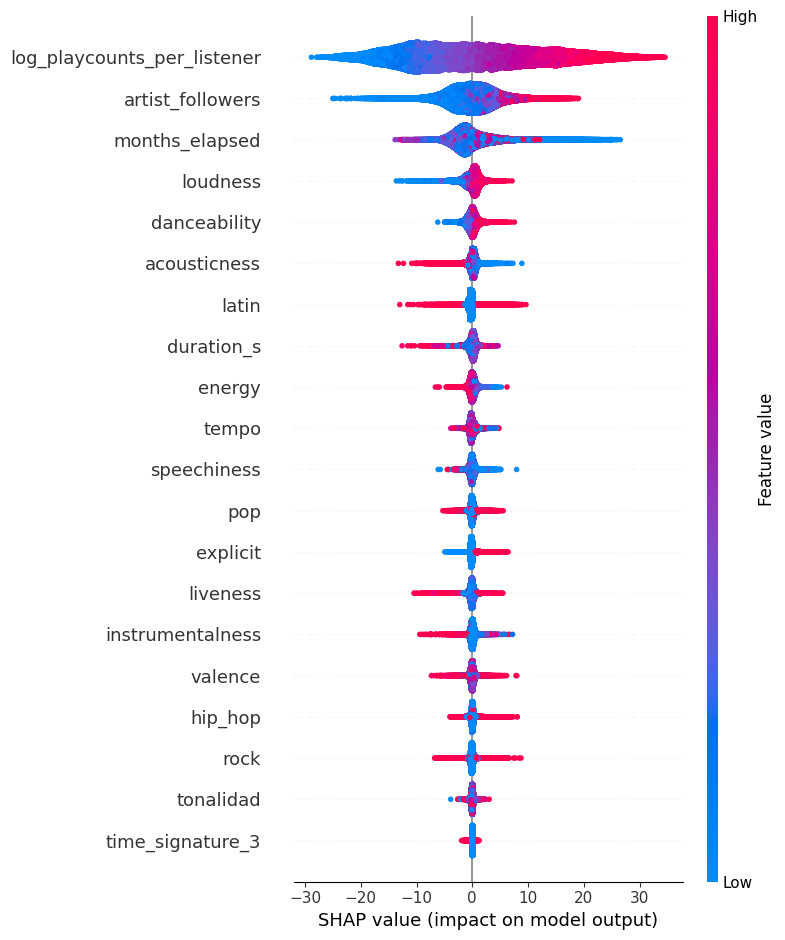

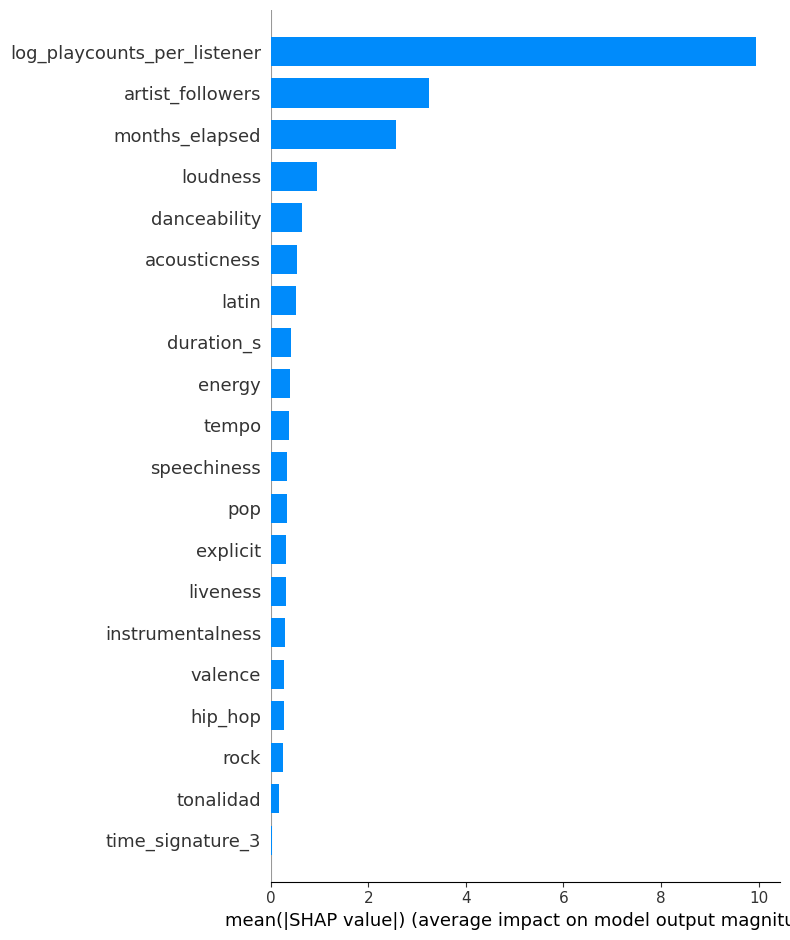

In [45]:


# Calcular los valores SHAP
explainer = shap.Explainer(xgb_pipeline.named_steps['model'])
shap_values = explainer(X_train_transformed)

# Visualizar los valores SHAP
shap.summary_plot(shap_values, X_train_transformed, feature_names=passthrough_columns)

# Visualizar la gráfica de importancia de las características
shap.summary_plot(shap_values, X_train_transformed, feature_names=passthrough_columns, plot_type="bar")


In [728]:
# XGB SHAP a modelo entrenado
with open('model/xgb_shap_model.pkl', 'wb') as files:
    pickle.dump(xgb, files)